In [6]:
from pathlib import Path
import os
import random

import numpy as np
import pandas as pd


In [33]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

FD_TAGS = ["FD001"]

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [ ]:
zip_path = DATA_DIR / "CMAPSSData.zip"

if not zip_path.exists():
    os.system(f"wget https://data.nasa.gov/docs/legacy/CMAPSSData.zip -O {zip_path}")

os.system(f"unzip -o {zip_path} -d {DATA_DIR}")
print("Data downloaded and extracted.")

In [34]:
# The dataset has 26 columns
# 1. Unit Number (Which engine is it?)
# 2. Time Cycles (How long has it been running?)
# 3-5. Operational Settings (Altitude, Speed, etc.)
# 6-26. Sensor Readings (s1 to s21)

index_names = ["unit_nr", "time_cycles"]
setting_names = ["setting_1", "setting_2", "setting_3"]
sensor_names = [f"s_{i}" for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names
print("Column names:", col_names)

Column names: ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


In [35]:
def load_fd(fd_tag: str, data_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_path = data_dir / f"train_{fd_tag}.txt"
    test_path = data_dir / f"test_{fd_tag}.txt"
    rul_path = data_dir / f"RUL_{fd_tag}.txt"

    train_df = pd.read_csv(train_path, sep=r"\s+", header=None, names=col_names)
    test_df = pd.read_csv(test_path, sep=r"\s+", header=None, names=col_names)
    rul_df = pd.read_csv(rul_path, header=None, names=["RUL_truth"])

    max_cycle = train_df.groupby("unit_nr")["time_cycles"].max().rename("max_cycle")
    train_df = train_df.merge(max_cycle, left_on="unit_nr", right_index=True)
    train_df["RUL"] = train_df["max_cycle"] - train_df["time_cycles"]

    train_df["fd"] = fd_tag
    test_df["fd"] = fd_tag
    rul_df["fd"] = fd_tag

    return train_df, test_df, rul_df


In [36]:
def make_global_unit_ids(train_df: pd.DataFrame, test_df: pd.DataFrame, fd_tag: str, next_unit: int):
    uniq_units_train = sorted(train_df["unit_nr"].unique())
    mapping_train = {u: next_unit + i for i, u in enumerate(uniq_units_train)}

    train_df = train_df.assign(
        unit_nr_orig=train_df["unit_nr"],
        unit_nr=train_df["unit_nr"].map(mapping_train),
    )

    test_df = test_df.assign(
        unit_nr_orig=test_df["unit_nr"],
        unit_nr=test_df["unit_nr"] + next_unit - 1,
    )

    next_unit = next_unit + len(uniq_units_train)
    return train_df, test_df, next_unit


In [11]:
next_unit = 1
train_parts = []
test_parts = []
rul_parts = []

for fd_tag in FD_TAGS:
    tr, te, rul = load_fd(fd_tag, DATA_DIR)

    tr, te, next_unit = make_global_unit_ids(tr, te, fd_tag, next_unit)

    train_parts.append(tr)
    test_parts.append(te)
    rul_parts.append(rul)

train_df = pd.concat(train_parts, ignore_index=True)
test_df = pd.concat(test_parts, ignore_index=True)
rul_labels_df = pd.concat(rul_parts, ignore_index=True)

train_df = train_df.sort_values(["unit_nr", "time_cycles"]).reset_index(drop=True)
test_df = test_df.sort_values(["unit_nr", "time_cycles"]).reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("RUL labels shape:", rul_labels_df.shape)
print("Unique train units:", train_df["unit_nr"].nunique())
print("Unique test units:", test_df["unit_nr"].nunique())


Train shape: (45351, 30)
Test shape: (29692, 28)
RUL labels shape: (200, 2)
Unique train units: 200
Unique test units: 200


EDA

In [37]:
missing_rate = train_df.isna().mean().sort_values(ascending=False)
print("Top missing rates:")
print(missing_rate.head(10))

dup_count = train_df.duplicated().sum()
print("Duplicate rows:", dup_count)


Top missing rates:
unit_nr        0.0
time_cycles    0.0
setting_1      0.0
setting_2      0.0
setting_3      0.0
s_1            0.0
s_2            0.0
s_3            0.0
s_4            0.0
s_5            0.0
dtype: float64
Duplicate rows: 0


In [38]:
bad_units = []
for unit_id, g in train_df.groupby("unit_nr", sort=False):
    cycles = g["time_cycles"].to_numpy()
    cycles_sorted = np.sort(cycles)

    diffs = cycles_sorted[1:] - cycles_sorted[:-1]
    ok_start = cycles_sorted[0] == 1
    ok_steps = (diffs.min() == 1) and (diffs.max() == 1)

    if not (ok_start and ok_steps):
        bad_units.append(unit_id)

print("Units with non-continuous cycles:", len(bad_units))


Units with non-continuous cycles: 0


In [39]:
lifetimes = train_df.groupby("unit_nr")["time_cycles"].max()
print(lifetimes.describe())

print(train_df["RUL"].describe())


count    200.000000
mean     226.755000
std       72.176605
min      128.000000
25%      181.000000
50%      204.500000
75%      256.250000
max      525.000000
Name: time_cycles, dtype: float64
count    45351.000000
mean       124.307049
std         87.813757
min          0.000000
25%         56.000000
50%        113.000000
75%        173.000000
max        524.000000
Name: RUL, dtype: float64


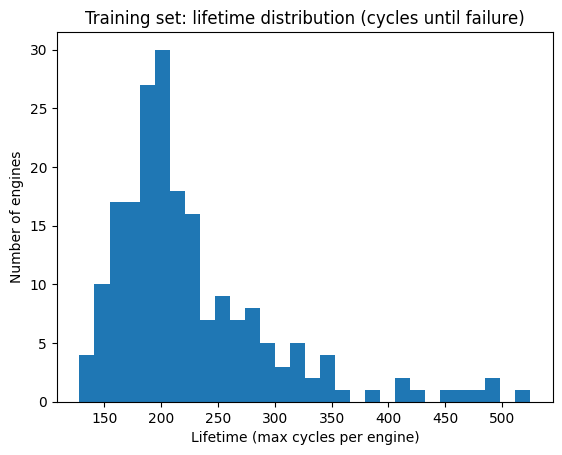

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(lifetimes, bins=30)
plt.title("Training set: lifetime distribution (cycles until failure)")
plt.xlabel("Lifetime (max cycles per engine)")
plt.ylabel("Number of engines")
plt.show()


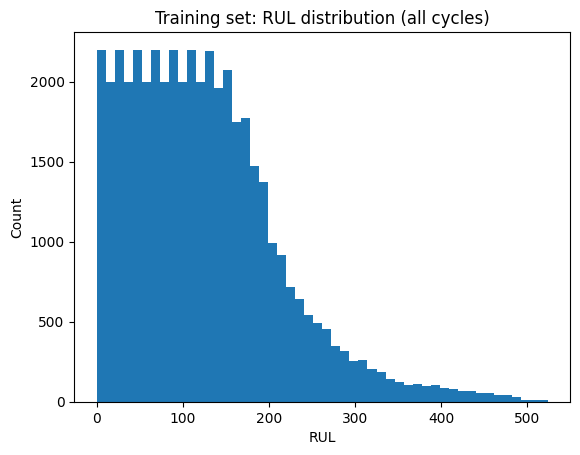

In [41]:
plt.figure()
plt.hist(train_df["RUL"], bins=50)
plt.title("Training set: RUL distribution (all cycles)")
plt.xlabel("RUL")
plt.ylabel("Count")
plt.show()


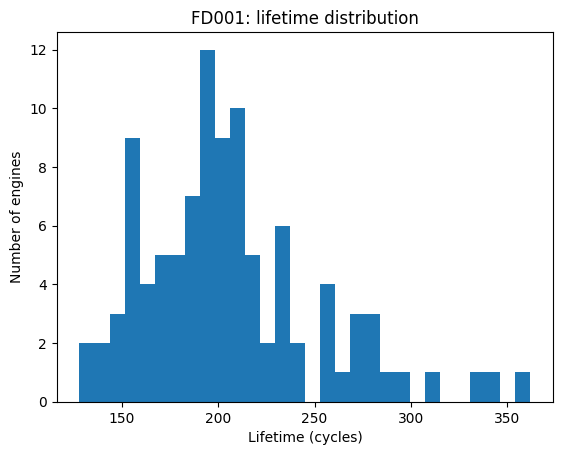

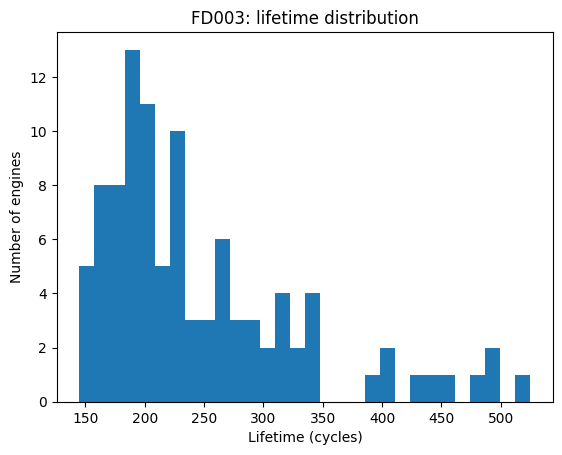

In [42]:
for fd_tag, g in train_df.groupby("fd"):
    lifetimes_fd = g.groupby("unit_nr")["time_cycles"].max()

    plt.figure()
    plt.hist(lifetimes_fd, bins=30)
    plt.title(f"{fd_tag}: lifetime distribution")
    plt.xlabel("Lifetime (cycles)")
    plt.ylabel("Number of engines")
    plt.show()


In [43]:
feature_cols = setting_names + sensor_names

desc = train_df[feature_cols].describe().T
desc["range"] = desc["max"] - desc["min"]
desc["std"] = train_df[feature_cols].std(numeric_only=True)

desc_sorted = desc.sort_values("range")
print(desc_sorted[["min", "max", "range", "std"]].head(10))


                 min        max   range           std
s_1         518.6700   518.6700  0.0000  1.136881e-13
setting_3   100.0000   100.0000  0.0000  0.000000e+00
s_5          14.6200    14.6200  0.0000  3.552753e-15
s_16          0.0300     0.0300  0.0000  6.938970e-18
s_18       2388.0000  2388.0000  0.0000  0.000000e+00
s_19        100.0000   100.0000  0.0000  0.000000e+00
setting_2    -0.0006     0.0007  0.0013  2.935970e-04
setting_1    -0.0087     0.0087  0.0174  2.190701e-03
s_10          1.2900     1.3200  0.0300  2.644938e-03
s_6          21.4500    21.6100  0.1600  1.510314e-02


In [44]:
range_thresh = 1e-6
std_thresh = 1e-6

low_variance = desc[(desc["range"] <= range_thresh) | (desc["std"] <= std_thresh)].index.tolist()
print("Low-variance features:", low_variance)


Low-variance features: ['setting_3', 's_1', 's_5', 's_16', 's_18', 's_19']


In [45]:
corrs = {}
sample_df = train_df.sample(n=min(len(train_df), 30000), random_state=SEED)

for c in feature_cols:
    corrs[c] = sample_df[c].corr(sample_df["RUL"], method="spearman")

corr_s = pd.Series(corrs).sort_values(key=lambda x: x.abs(), ascending=False)
print("Top correlations (abs Spearman):")
print(corr_s.head(20))


Top correlations (abs Spearman):
s_11        -0.750762
s_4         -0.723617
s_13        -0.683979
s_8         -0.682411
s_17        -0.681980
s_3         -0.653291
s_2         -0.649744
s_9         -0.471446
s_15        -0.386884
s_21         0.372860
s_20         0.371359
s_14        -0.353259
s_10        -0.301496
s_7          0.262576
s_12         0.257145
s_6         -0.246726
setting_2   -0.004564
setting_1    0.001457
setting_3         NaN
s_1               NaN
dtype: float64


/home/limin/Documents/programming/gemini-lstm-next-frame-prediction/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


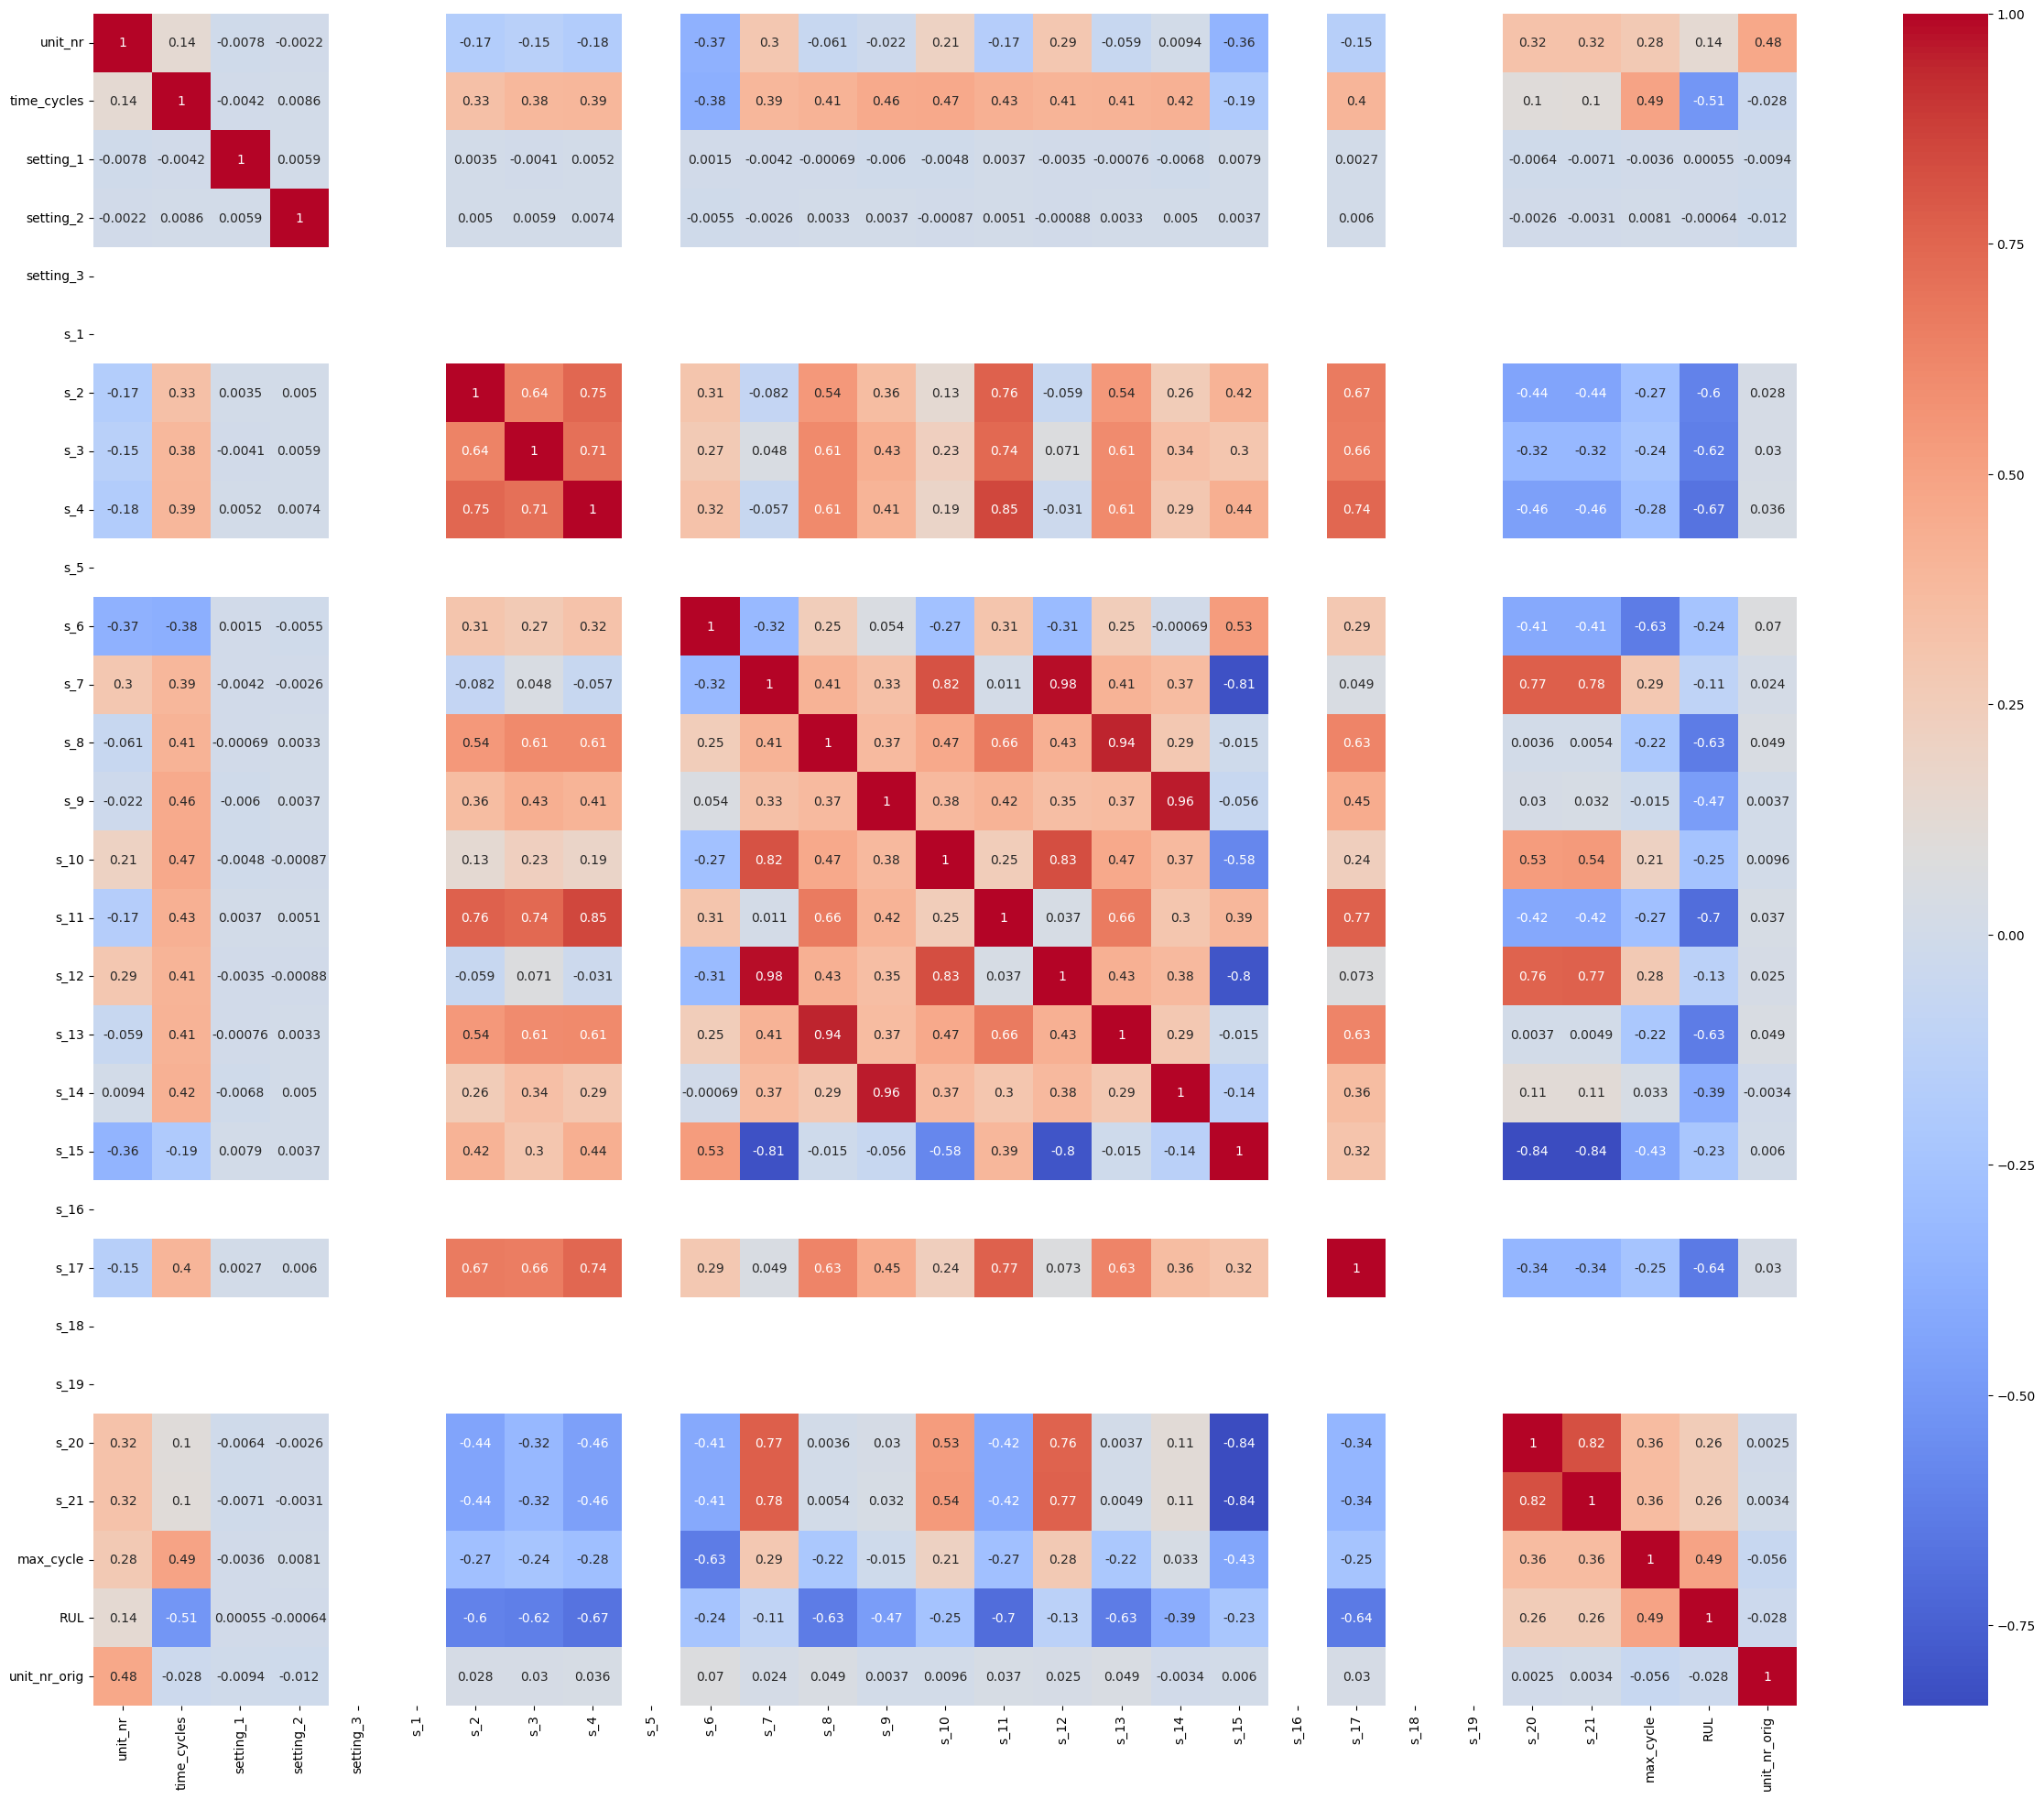

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric = train_df.select_dtypes(include=["number"])
corr_matrix = numeric.corr()

plt.figure(figsize=(30, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


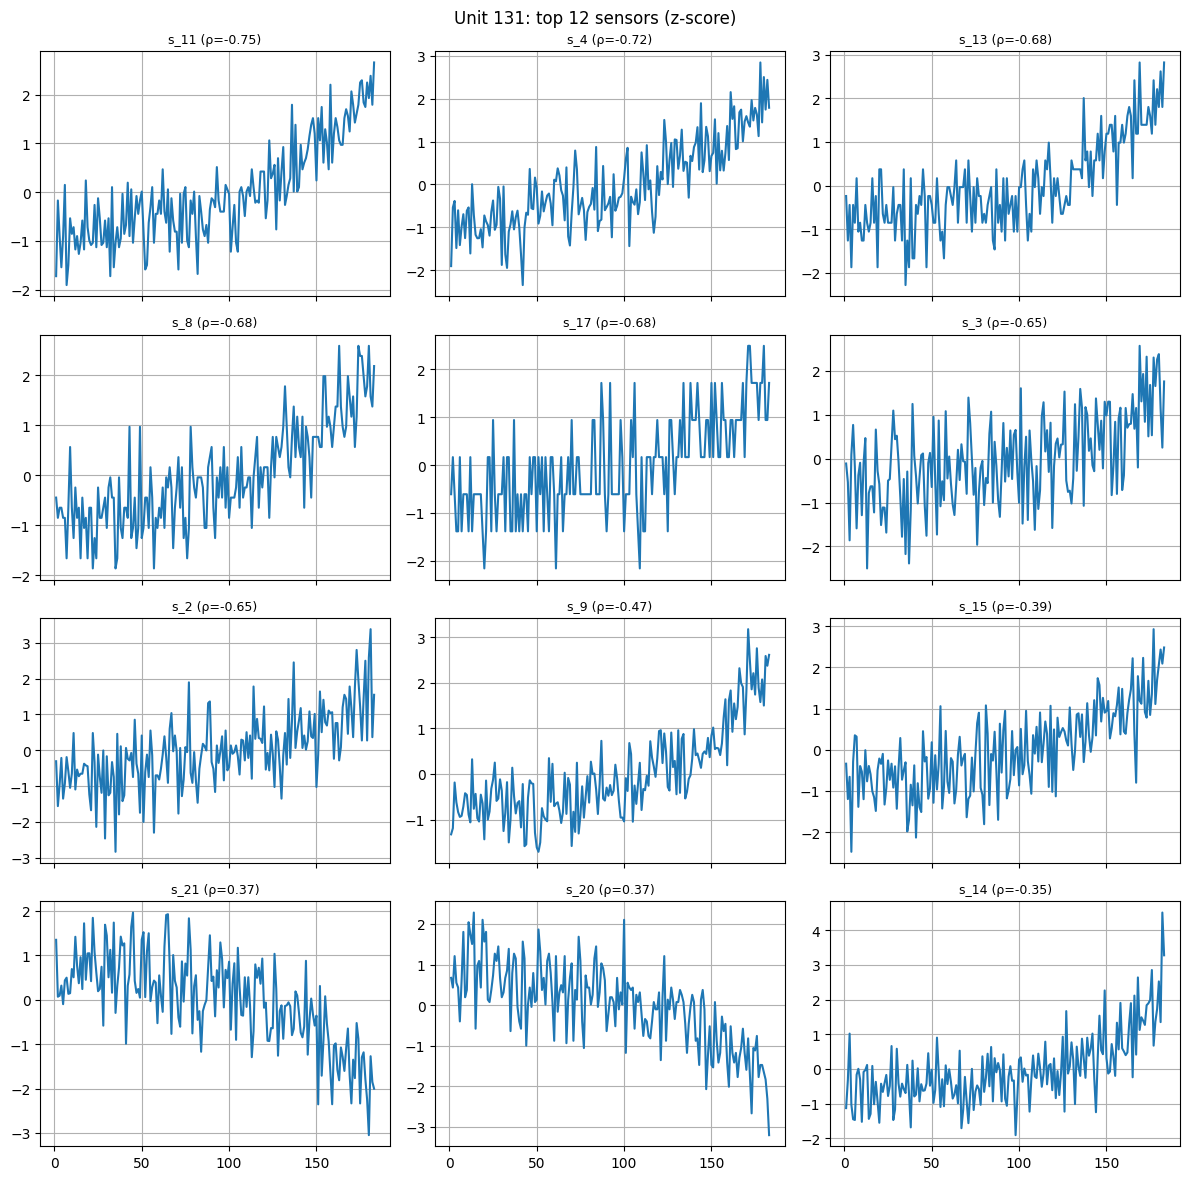

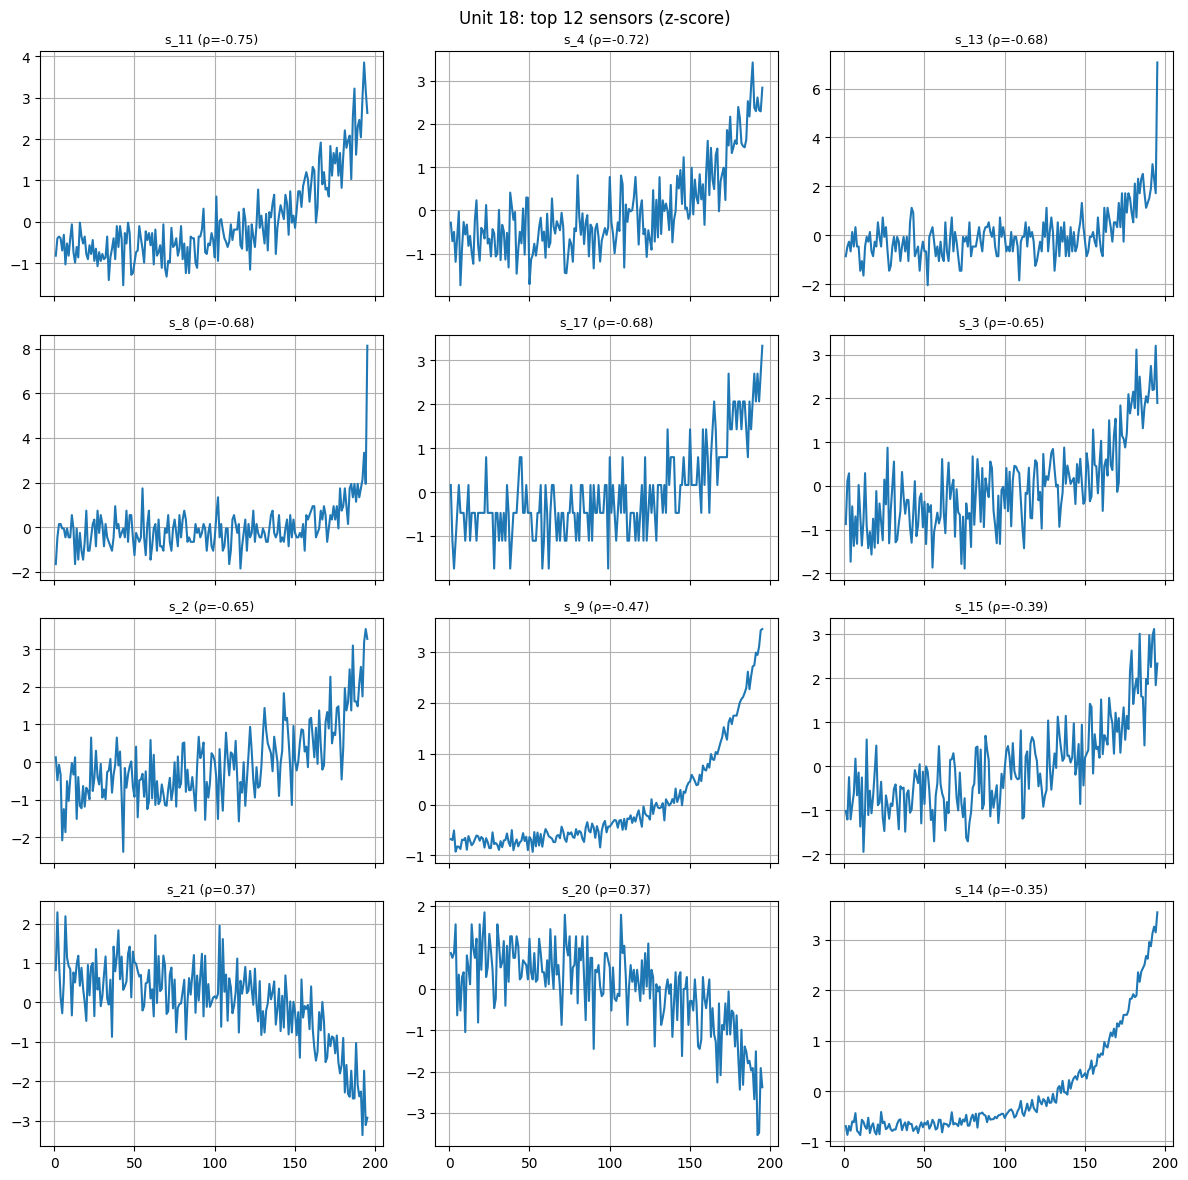

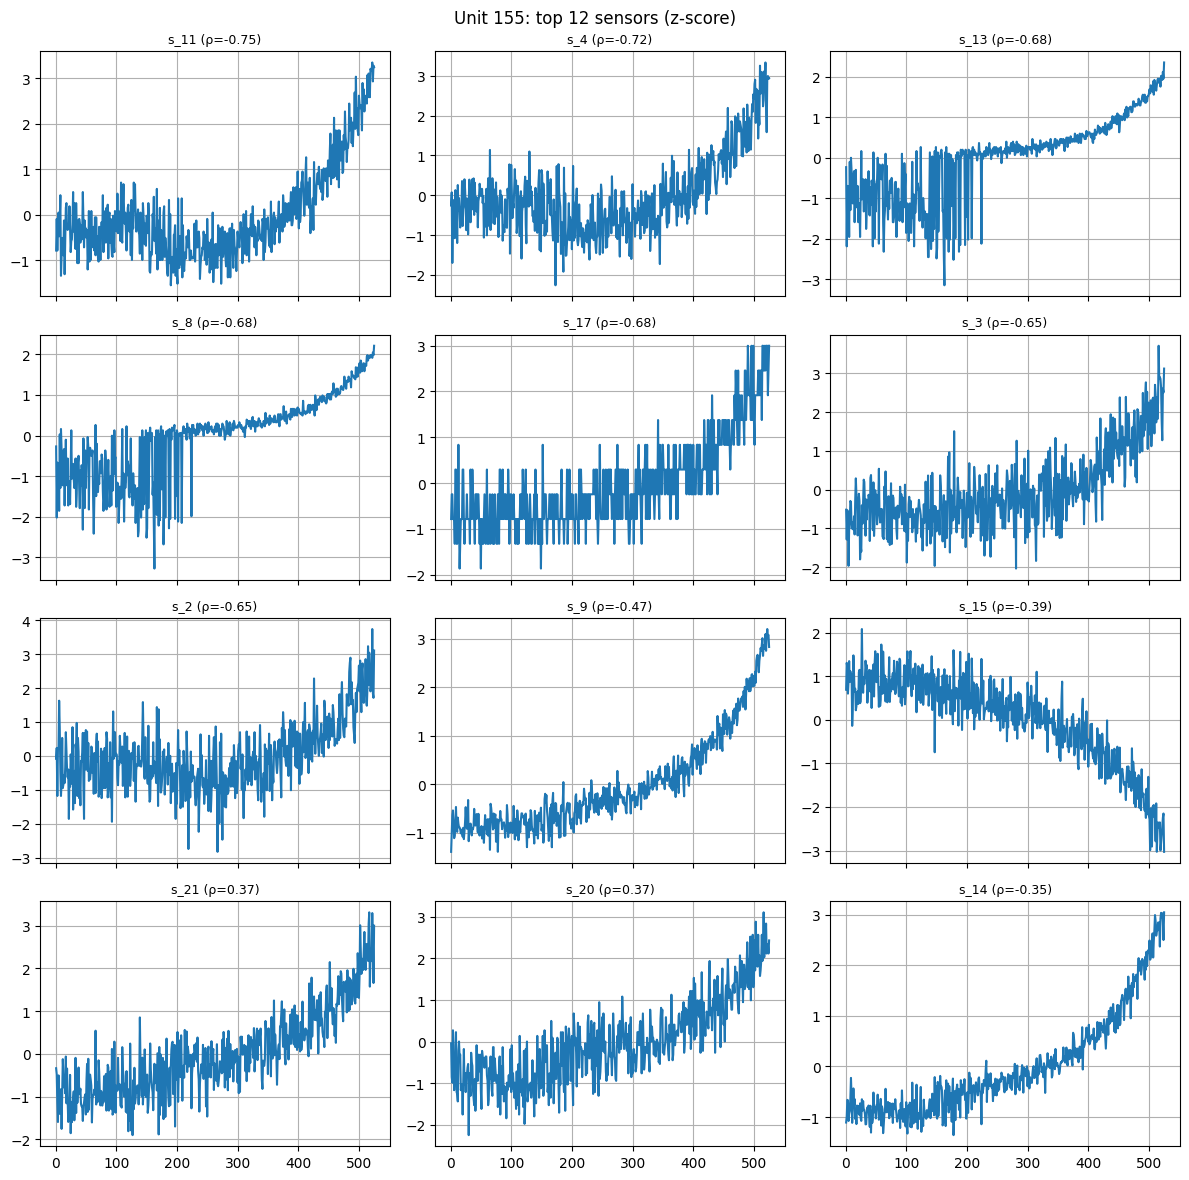

In [48]:
top_n = 12
top_sensors = corr_s.head(top_n).index.tolist()

for unit_id in units_to_plot:
    g = train_df[train_df["unit_nr"] == unit_id].sort_values("time_cycles")

    X = g[top_sensors].to_numpy()
    Xz = StandardScaler().fit_transform(X)

    cols = 3
    rows = (top_n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows), sharex=True)
    axes = axes.ravel()

    for i, s in enumerate(top_sensors):
        axes[i].plot(g["time_cycles"], Xz[:, i])
        axes[i].set_title(f"{s} (ρ={corr_s[s]:.2f})", fontsize=9)
        axes[i].grid(True)

    for ax in axes[top_n:]:
        ax.axis("off")

    fig.suptitle(f"Unit {unit_id}: top {top_n} sensors (z-score)")
    plt.tight_layout()
    plt.show()


EDA END

In [ ]:
def split_by_unit(df: pd.DataFrame, val_frac: float, seed: int):
    units = df["unit_nr"].unique()
    rng = np.random.default_rng(seed)
    rng.shuffle(units)

    n_val = int(np.ceil(len(units) * val_frac))
    val_units = set(units[:n_val])
    train_units = set(units[n_val:])

    train_split = df[df["unit_nr"].isin(train_units)].copy()
    val_split = df[df["unit_nr"].isin(val_units)].copy()

    return train_split, val_split, sorted(train_units), sorted(val_units)

train_split_df, val_split_df, train_units, val_units = split_by_unit(train_df, val_frac=0.2, seed=SEED)

print("Train split shape:", train_split_df.shape, "units:", len(train_units))
print("Val split shape:", val_split_df.shape, "units:", len(val_units))


END

In [ ]:
# The dataset has 26 columns
# 1. Unit Number (Which engine is it?)
# 2. Time Cycles (How long has it been running?)
# 3-5. Operational Settings (Altitude, Speed, etc.)
# 6-26. Sensor Readings (s1 to s21)

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

print(col_names)

def load_fd(fd_tag):
    train_path = f"data/train_{fd_tag}.txt"
    test_path  = f"data/test_{fd_tag}.txt"
    rul_path   = f"data/RUL_{fd_tag}.txt"

    raw_train_df = pd.read_csv(train_path, sep=r'\s+', header=None, names=col_names)
    raw_test_df  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=col_names)
    raw_rul_labels_df = pd.read_csv(rul_path, header=None, names=['RUL_truth'])

    # train labels: compute RUL from run-to-failure
    max_cycle = raw_train_df.groupby('unit_nr')['time_cycles'].max().rename('max_cycle')
    raw_train_df = raw_train_df.merge(max_cycle, left_on='unit_nr', right_index=True)
    raw_train_df['RUL'] = raw_train_df['max_cycle'] - raw_train_df['time_cycles']

    # test labels: provided separately
    return raw_train_df, raw_test_df, raw_rul_labels_df

next_unit = 1
train_dfs = []
test_dfs = []
test_rul_labels = []

data_tags = ["FD001"]

for fd_tag in data_tags:
    train_df_chunk, test_df_chunk, rul_labels_chunk = load_fd(fd_tag)
    train_df_chunk['fd'] = fd_tag
    test_df_chunk['fd'] = fd_tag
    test_df_chunk = test_df_chunk.assign(
        unit_nr_orig=test_df_chunk['unit_nr'],
        unit_nr=test_df_chunk['unit_nr'] + next_unit - 1
    )
    test_dfs.append(test_df_chunk)
    test_rul_labels.append(rul_labels_chunk)

    # make a mapping for this FD's units
    uniq_units = sorted(train_df_chunk['unit_nr'].unique())
    mapping = {u: next_unit + i for i, u in enumerate(uniq_units)}
    next_unit += len(uniq_units)

    train_df_chunk = train_df_chunk.assign(
        unit_nr_orig=train_df_chunk['unit_nr'],
        unit_nr=train_df_chunk['unit_nr'].map(mapping),
        fd=fd_tag
    )
    train_dfs.append(train_df_chunk)
    
    
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)
rul_labels_df = pd.concat(test_rul_labels, ignore_index=True)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL labels shape: {rul_labels_df.shape}")

engine_ids = train_df['unit_nr'].unique()

train_ids = engine_ids[:80]
val_ids = engine_ids[80:]
print("len train ids:", len(train_ids))
print("len val ids:", len(val_ids))
print("len engine ids:", len(engine_ids))

train_split_df = train_df[train_df['unit_nr'].isin(train_ids)]
val_split_df = train_df[train_df['unit_nr'].isin(val_ids)]
print("Train df shape:", train_split_df.shape)
print("Val df shape:", val_split_df.shape)




In [ ]:
next_unit = 1
train_parts = []
test_parts = []
rul_parts = []

for fd_tag in FD_TAGS:
    tr, te, rul = load_fd(fd_tag, DATA_DIR)

    tr, te, next_unit = make_global_unit_ids(tr, te, fd_tag, next_unit)

    train_parts.append(tr)
    test_parts.append(te)
    rul_parts.append(rul)

train_df = pd.concat(train_parts, ignore_index=True)
test_df = pd.concat(test_parts, ignore_index=True)
rul_labels_df = pd.concat(rul_parts, ignore_index=True)

train_df = train_df.sort_values(["unit_nr", "time_cycles"]).reset_index(drop=True)
test_df = test_df.sort_values(["unit_nr", "time_cycles"]).reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("RUL labels shape:", rul_labels_df.shape)
print("Unique train units:", train_df["unit_nr"].nunique())
print("Unique test units:", test_df["unit_nr"].nunique())


In [ ]:
def split_by_unit(df: pd.DataFrame, val_frac: float, seed: int):
    units = df["unit_nr"].unique()
    rng = np.random.default_rng(seed)
    rng.shuffle(units)

    n_val = int(np.ceil(len(units) * val_frac))
    val_units = set(units[:n_val])
    train_units = set(units[n_val:])

    train_split = df[df["unit_nr"].isin(train_units)].copy()
    val_split = df[df["unit_nr"].isin(val_units)].copy()

    return train_split, val_split, sorted(train_units), sorted(val_units)

train_split_df, val_split_df, train_units, val_units = split_by_unit(train_df, val_frac=0.2, seed=SEED)

print("Train split shape:", train_split_df.shape, "units:", len(train_units))
print("Val split shape:", val_split_df.shape, "units:", len(val_units))


EDA

In [ ]:
missing_rate = train_df.isna().mean().sort_values(ascending=False)
print("Top missing rates:")
print(missing_rate.head(10))

dup_count = train_df.duplicated().sum()
print("Duplicate rows:", dup_count)


In [ ]:
bad_units = []
for unit_id, g in train_df.groupby("unit_nr", sort=False):
    cycles = g["time_cycles"].to_numpy()
    cycles_sorted = np.sort(cycles)

    diffs = cycles_sorted[1:] - cycles_sorted[:-1]
    ok_start = cycles_sorted[0] == 1
    ok_steps = (diffs.min() == 1) and (diffs.max() == 1)

    if not (ok_start and ok_steps):
        bad_units.append(unit_id)

print("Units with non-continuous cycles:", len(bad_units))


In [ ]:
lifetimes = train_df.groupby("unit_nr")["time_cycles"].max()
print(lifetimes.describe())

print(train_df["RUL"].describe())


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(lifetimes, bins=30)
plt.title("Training set: lifetime distribution (cycles until failure)")
plt.xlabel("Lifetime (max cycles per engine)")
plt.ylabel("Number of engines")
plt.show()


In [ ]:
plt.figure()
plt.hist(train_df["RUL"], bins=50)
plt.title("Training set: RUL distribution (all cycles)")
plt.xlabel("RUL")
plt.ylabel("Count")
plt.show()


In [ ]:
for fd_tag, g in train_df.groupby("fd"):
    lifetimes_fd = g.groupby("unit_nr")["time_cycles"].max()

    plt.figure()
    plt.hist(lifetimes_fd, bins=30)
    plt.title(f"{fd_tag}: lifetime distribution")
    plt.xlabel("Lifetime (cycles)")
    plt.ylabel("Number of engines")
    plt.show()


In [ ]:
feature_cols = setting_names + sensor_names

desc = train_split_df[feature_cols].describe().T
desc["range"] = desc["max"] - desc["min"]
desc["std"] = train_split_df[feature_cols].std(numeric_only=True)

desc_sorted = desc.sort_values("range")
print(desc_sorted[["min", "max", "range", "std"]].head(10))


In [ ]:
range_thresh = 1e-6
std_thresh = 1e-6

low_variance = desc[(desc["range"] <= range_thresh) | (desc["std"] <= std_thresh)].index.tolist()
print("Low-variance features:", low_variance)


In [ ]:
corrs = {}
sample_df = train_split_df.sample(n=min(len(train_split_df), 30000), random_state=SEED)

for c in feature_cols:
    corrs[c] = sample_df[c].corr(sample_df["RUL"], method="spearman")

corr_s = pd.Series(corrs).sort_values(key=lambda x: x.abs(), ascending=False)
print("Top correlations (abs Spearman):")
print(corr_s.head(10))


In [ ]:
import matplotlib.pyplot as plt

units_to_plot = np.random.default_rng(SEED).choice(train_df["unit_nr"].unique(), size=3, replace=False).tolist()
sensors_to_plot = ["s_2", "s_3", "s_4"]

for unit_id in units_to_plot:
    g = train_df[train_df["unit_nr"] == unit_id].sort_values("time_cycles")

    plt.figure()
    for s in sensors_to_plot:
        plt.plot(g["time_cycles"], g[s], label=s)

    plt.title(f"Unit {unit_id}: sensor trajectories")
    plt.xlabel("Cycle")
    plt.ylabel("Sensor value")
    plt.legend()
    plt.show()


In [ ]:
from typing import List, Tuple
import torch
from torch.nn.utils.rnn import pad_sequence


def collate_pad(batch: List[Tuple[torch.Tensor, float, int]]):
    seqs, targets, lengths = zip(*batch)

    lengths_t = torch.tensor(lengths, dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True)
    targets_t = torch.tensor(targets, dtype=torch.float32)

    return padded.float(), lengths_t, targets_t


In [ ]:
from torch.utils.data import DataLoader
from dataset import CmapssRandomCropDataset

def make_loader(sequences_by_unit, rul_by_unit, samples_per_epoch, batch_size, l_min, l_max, num_workers=0):
    ds = CmapssRandomCropDataset(
        sequences_by_unit=sequences_by_unit,
        rul_by_unit=rul_by_unit,
        samples_per_epoch=samples_per_epoch,
        l_min=l_min,
        l_max=l_max,
    )

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_pad,
        drop_last=True,
        pin_memory=True,
    )

    return loader


In [ ]:
import torch
import torch.nn as nn


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    loss_fn = nn.SmoothL1Loss()

    total_loss = 0.0
    n = 0

    for padded, lengths, targets in loader:
        padded = padded.to(device)
        lengths = lengths.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        preds = model(padded, lengths)
        loss = loss_fn(preds, targets)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        bs = targets.shape[0]
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)


In [ ]:
import pandas as pd

# The dataset has 26 columns
# 1. Unit Number (Which engine is it?)
# 2. Time Cycles (How long has it been running?)
# 3-5. Operational Settings (Altitude, Speed, etc.)
# 6-26. Sensor Readings (s1 to s21)

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

print(col_names)

def load_fd(fd_tag):
    train_path = f"data/train_{fd_tag}.txt"
    test_path  = f"data/test_{fd_tag}.txt"
    rul_path   = f"data/RUL_{fd_tag}.txt"

    raw_train_df = pd.read_csv(train_path, sep=r'\s+', header=None, names=col_names)
    raw_test_df  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=col_names)
    raw_rul_labels_df = pd.read_csv(rul_path, header=None, names=['RUL_truth'])

    # train labels: compute RUL from run-to-failure
    max_cycle = raw_train_df.groupby('unit_nr')['time_cycles'].max().rename('max_cycle')
    raw_train_df = raw_train_df.merge(max_cycle, left_on='unit_nr', right_index=True)
    raw_train_df['RUL'] = raw_train_df['max_cycle'] - raw_train_df['time_cycles']

    # test labels: provided separately
    return raw_train_df, raw_test_df, raw_rul_labels_df

next_unit = 1
train_dfs = []
test_dfs = []
test_rul_labels = []

data_tags = ["FD001","FD002","FD003","FD004"]
data_tags = ["FD001", "FD003"]
#data_tags = ["FD001"]

for fd_tag in data_tags:
    train_df_chunk, test_df_chunk, rul_labels_chunk = load_fd(fd_tag)
    train_df_chunk['fd'] = fd_tag
    test_df_chunk['fd'] = fd_tag
    test_df_chunk = test_df_chunk.assign(
        unit_nr_orig=test_df_chunk['unit_nr'],
        unit_nr=test_df_chunk['unit_nr'] + next_unit - 1
    )
    test_dfs.append(test_df_chunk)
    test_rul_labels.append(rul_labels_chunk)

    # make a mapping for this FD's units
    uniq_units = sorted(train_df_chunk['unit_nr'].unique())
    mapping = {u: next_unit + i for i, u in enumerate(uniq_units)}
    next_unit += len(uniq_units)

    train_df_chunk = train_df_chunk.assign(
        unit_nr_orig=train_df_chunk['unit_nr'],
        unit_nr=train_df_chunk['unit_nr'].map(mapping),
        fd=fd_tag
    )
    train_dfs.append(train_df_chunk)
    
    
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)
rul_labels_df = pd.concat(test_rul_labels, ignore_index=True)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL labels shape: {rul_labels_df.shape}")

engine_ids = train_df['unit_nr'].unique()

train_ids = engine_ids[:150]
val_ids = engine_ids[150:]
print("len train ids:", len(train_ids))
print("len val ids:", len(val_ids))
print("len engine ids:", len(engine_ids))

train_split_df = train_df[train_df['unit_nr'].isin(train_ids)]
val_split_df = train_df[train_df['unit_nr'].isin(val_ids)]
print("Train df shape:", train_split_df.shape)
print("Val df shape:", val_split_df.shape)




EDA

In [ ]:
# Missing values per column
missing = train_df.isna().mean().sort_values(ascending=False)
print(missing.head(10))

# Duplicate rows check
dup_count = train_df.duplicated().sum()
print("Duplicate rows:", dup_count)


In [ ]:
# Check cycle continuity per unit
gaps = []
for unit_id, g in train_df.groupby("unit_nr"):
    cycles = g["time_cycles"].sort_values().to_numpy()
    if not (cycles[0] == 1 and (cycles[1:] - cycles[:-1]).min() == 1):
        gaps.append(unit_id)

print("Units with non-continuous cycles:", len(gaps))


In [ ]:
# Per-unit lifetime distribution
lifetimes = train_df.groupby("unit_nr")["time_cycles"].max()
print(lifetimes.describe())

# RUL distribution
print(train_df["RUL"].describe())


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(lifetimes, bins=30)
plt.title("Lifetime distribution (cycles until failure) - training set")
plt.xlabel("Lifetime (max cycles per engine)")
plt.ylabel("Number of engines")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

columns_to_scale = setting_names + sensor_names

ranges = (train_split_df[columns_to_scale].max() - train_split_df[columns_to_scale].min()).sort_values(ascending=False)

plt.figure()
plt.bar(np.arange(len(ranges)), ranges.to_numpy())
plt.title("Per-feature range before scaling (train split)")
plt.xlabel("feature rank")
plt.ylabel("range")
plt.show()

scaled_ranges = (scaled_train_split_df[columns_to_scale].max() - scaled_train_split_df[columns_to_scale].min()).sort_values(ascending=False)

plt.figure()
plt.bar(np.arange(len(scaled_ranges)), scaled_ranges.to_numpy())
plt.title("Per-feature range after MinMax scaling (train split)")
plt.xlabel("feature rank")
plt.ylabel("range")
plt.show()


In [ ]:
test_df.head()

In [ ]:
rul_labels_df.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler


not_scaled_cols = ['unit_nr', 'RUL', 'max_cycle', 'time_cycles']

col_set = set(col_names)
columns_to_scale = [col for col in col_names if col not in not_scaled_cols]

print("Columns to scale:", columns_to_scale)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_split = scaler.fit_transform(train_split_df[columns_to_scale])
scaled_train_split_df = pd.DataFrame(scaled_train_split, columns=columns_to_scale, index=train_split_df.index)
scaled_val_split = scaler.transform(val_split_df[columns_to_scale])
scaled_val_split_df = pd.DataFrame(scaled_val_split, columns=columns_to_scale, index=val_split_df.index)
scaled_test = scaler.transform(test_df[columns_to_scale])
scaled_test_df = pd.DataFrame(scaled_test, columns=columns_to_scale, index=test_df.index)


scaled_train_split_df.insert(0, 'unit_nr', train_split_df['unit_nr'])
scaled_train_split_df.insert(1, 'time_cycles', train_split_df['time_cycles'])
scaled_train_split_df.insert(len(scaled_train_split_df.columns), 'RUL', train_split_df['RUL'])
scaled_train_split_df.insert(len(scaled_train_split_df.columns), 'max_cycle', train_split_df['max_cycle'])

scaled_val_split_df.insert(0, 'unit_nr', val_split_df['unit_nr'])
scaled_val_split_df.insert(1, 'time_cycles', val_split_df['time_cycles'])
scaled_val_split_df.insert(len(scaled_val_split_df.columns), 'RUL', val_split_df['RUL'])
scaled_val_split_df.insert(len(scaled_val_split_df.columns), 'max_cycle', val_split_df['max_cycle'])

scaled_test_df.insert(0, 'unit_nr', test_df['unit_nr'])
scaled_test_df.insert(1, 'time_cycles', test_df['time_cycles'])




In [ ]:
scaled_test_df.head()

In [ ]:
scaled_train_split_df.info()


In [ ]:
scaled_val_split_df.info()
scaled_val_split_df.head()

In [ ]:
sequences_by_unit = {}
rul_by_unit = {}

#feature_cols = col_names[2:]  # Exclude 'unit_nr' and 'time_cycles'
features_to_drop = ['unit_nr', 'time_cycles', 'RUL', 'max_cycle', "s_1", "s_5", "s_10", "s_16", "s_18", "s_19"]
feature_cols = [c for c in col_names if c not in features_to_drop]



import torch

def build_unit_dicts(df, feature_cols):
    sequences_by_unit = {}
    rul_by_unit = {}

    df = df.sort_values(["unit_nr", "time_cycles"])

    for unit_id, g in df.groupby("unit_nr", sort=False):
        x = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
        y = torch.tensor(g["RUL"].to_numpy(), dtype=torch.float32)

        sequences_by_unit[int(unit_id)] = x
        rul_by_unit[int(unit_id)] = y

    return sequences_by_unit, rul_by_unit

train_sequences_by_unit, train_rul_by_unit = build_unit_dicts(scaled_train_split_df, feature_cols)
val_sequences_by_unit, val_rul_by_unit = build_unit_dicts(scaled_val_split_df, feature_cols)

print("train_sequences_by_unit", len(train_sequences_by_unit))

from dataset import CmapssRandomCropDataset

dataset = CmapssRandomCropDataset(
    sequences_by_unit=train_sequences_by_unit,
    rul_by_unit=train_rul_by_unit,
    samples_per_epoch=1000,
    l_min=30,
    l_max=100,
)

seq, target, length = dataset[0]  # or dataset[42], same behavior
print(seq.shape, target, length)

train_loader = make_loader(train_sequences_by_unit, train_rul_by_unit, samples_per_epoch=60000, batch_size=32, l_min=30, l_max=100)
padded, lengths, targets = next(iter(train_loader))
print(padded.shape, lengths.shape, targets.shape)

val_loader = make_loader(val_sequences_by_unit, val_rul_by_unit, samples_per_epoch=14000, batch_size=32, l_min=30, l_max=200)
padded, lengths, targets = next(iter(val_loader))
print(padded.shape, lengths.shape, targets.shape)



In [ ]:
import torch

def build_test_sequences(df, feature_cols):
    sequences = {}
    df = df.sort_values(["unit_nr", "time_cycles"])

    for unit_id, g in df.groupby("unit_nr", sort=False):
        x = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
        sequences[int(unit_id)] = x

    return sequences

test_sequences_by_unit = build_test_sequences(scaled_test_df, feature_cols)

rul_truth = rul_labels_df["RUL_truth"].to_numpy().astype(float)
test_unit_ids = sorted(test_sequences_by_unit.keys())

test_targets_by_unit = {unit_id: float(rul_truth[i]) for i, unit_id in enumerate(test_unit_ids)}
print("test_sequences_by_unit", len(test_sequences_by_unit))
print("test_sequences_by_unit[0]", test_sequences_by_unit[1].shape)

In [ ]:
from torch.utils.data import Dataset

class CmapssLastWindowDataset(Dataset):
    def __init__(self, sequences_by_unit, targets_by_unit, window_len: int):
        self.sequences_by_unit = sequences_by_unit
        self.targets_by_unit = targets_by_unit
        self.window_len = window_len
        self.unit_ids = sorted(sequences_by_unit.keys())

    def __len__(self):
        return len(self.unit_ids)

    def __getitem__(self, idx):
        unit_id = self.unit_ids[idx]
        seq = self.sequences_by_unit[unit_id]
        target = self.targets_by_unit[unit_id]

        if self.window_len is not None and seq.shape[0] > self.window_len:
            seq = seq[-self.window_len:]

        length = int(seq.shape[0])
        return seq, float(target), length
    
class CmapssFullDataset(Dataset):
    def __init__(self, sequences_by_unit, targets_by_unit):
        self.sequences_by_unit = sequences_by_unit
        self.targets_by_unit = targets_by_unit
        self.unit_ids = sorted(sequences_by_unit.keys())

    def __len__(self):
        return len(self.unit_ids)

    def __getitem__(self, idx):
        unit_id = self.unit_ids[idx]
        seq = self.sequences_by_unit[unit_id]
        target = self.targets_by_unit[unit_id]

        length = int(seq.shape[0])
        return seq, float(target), length
    





In [ ]:
from torch.utils.data import DataLoader

WINDOW_LEN = 100

test_ds = CmapssLastWindowDataset(
    sequences_by_unit=test_sequences_by_unit,
    targets_by_unit=test_targets_by_unit,
    window_len=WINDOW_LEN,
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_pad,
    drop_last=False,
    pin_memory=True,
)

test_ds = CmapssFullDataset(
    sequences_by_unit=test_sequences_by_unit,
    targets_by_unit=test_targets_by_unit,
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_pad,
    drop_last=False,
    pin_memory=True,
)


In [ ]:
import torch
import torch.nn as nn

def run_epoch(model, loader, loss_fn, device, train: bool, optimizer=None):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_samples = 0

    if train:
        context = torch.enable_grad()
    else:
        context = torch.no_grad()

    with context:
        for padded, lengths, targets in loader:
            padded = padded.to(device)
            lengths = lengths.to(device)
            targets = targets.to(device)

            preds = model(padded, lengths)
            loss = loss_fn(preds, targets)

            bs = targets.size(0)
            total_loss += loss.item() * bs
            total_samples += bs

            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

    return total_loss / max(total_samples, 1)


In [ ]:
import copy
from pathlib import Path
import os

EPOCHS = 20

if not os.path.exists('models'):
    os.makedirs('models')

def train_full(model, train_loader, val_loader, optimizer, device):
    loss_fn = nn.SmoothL1Loss(reduction="mean")

    best_val = float("inf")
    best_state = None

    for epoch in range(EPOCHS):
        train_loss = run_epoch(
            model=model,
            loader=train_loader,
            loss_fn=loss_fn,
            device=device,
            train=True,
            optimizer=optimizer,
        )

        val_loss = run_epoch(
            model=model,
            loader=val_loader,
            loss_fn=loss_fn,
            device=device,
            train=False,
            optimizer=None,
        )

        print(
            f"Epoch {epoch+1}/{EPOCHS} "
            f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f}"
        )

        if val_loss < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(best_state, 'models/lstm_model.pth')
        print("Model weights saved to models/lstm_model.pth")

    return best_val


In [ ]:
from model import RulLstm

model = RulLstm(
    n_features=len(feature_cols),
    hidden_size=128,
    num_layers=2,
    dropout=0.4,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

#loss = train_one_epoch(model, dataset_loader, optimizer, device)

loss = train_full(model, train_loader, val_loader, optimizer, device)

In [ ]:
model.to("cpu")
model.eval()

x = torch.randn(32, 217, 18)
lengths = torch.full((32,), 217, dtype=torch.long)  # or whatever your lengths are

torch.onnx.export(
    model,
    (x, lengths),
    "models/lstm_model.onnx",
    input_names=["input", "lengths"],
    output_names=["output"],
    opset_version=18,
    dynamic_axes={
        "input": {0: "batch_size", 1: "sequence_length"},
        "lengths": {0: "batch_size"},
    },
    dynamo=False,  # optional but avoids dynamo issues
)


In [ ]:
import numpy as np
import onnxruntime as ort

sess = ort.InferenceSession("models/lstm_model.onnx", providers=["CPUExecutionProvider"])

x = np.random.randn(1, 30, 18).astype(np.float32)
lengths = np.array([30], dtype=np.int64)
y = sess.run(None, {"input": x, "lengths": lengths})
print("Inference successful")

In [ ]:
import numpy as np
import onnxruntime as ort

sess = ort.InferenceSession("models/lstm_model.onnx", providers=["CPUExecutionProvider"])

#x = np.random.randn(1, 30, 18).astype(np.float32)
#lengths = np.array([30], dtype=np.int64)

seq, target, length = test_ds[20]

print("Evaluating test sequence with shape:", seq.shape)
print("Length:", length)
print("Target RUL:", target)

seq = seq.numpy().reshape(1, -1, seq.shape[1])

lengths = np.array([length], dtype=np.int64)
outputs = sess.run(None, {"input": seq, "lengths": lengths})

print("Number of outputs:", len(outputs))
for i, out in enumerate(outputs):
    print(f"Output[{i}] shape:", out.shape, "dtype:", out.dtype)
    print(f"Output[{i}] data:", out.item())  # Print the actual output data

In [ ]:
import numpy as np
import torch
import torch.nn as nn

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()

    smoothl1 = nn.SmoothL1Loss(reduction="mean")
    l1 = nn.L1Loss(reduction="mean")
    mse = nn.MSELoss(reduction="mean")

    total_smoothl1 = 0.0
    total_l1 = 0.0
    total_mse = 0.0
    total_samples = 0

    all_preds = []
    all_targets = []

    for padded, lengths, targets in loader:
        padded = padded.to(device)
        lengths = lengths.to(device)
        targets = targets.to(device)
        
        print("Evaluating batch with padded shape:", padded.shape)
        print("Lengths:", lengths)
        preds = model(padded, lengths)

        bs = targets.size(0)
        total_smoothl1 += smoothl1(preds, targets).item() * bs
        total_l1 += l1(preds, targets).item() * bs
        total_mse += mse(preds, targets).item() * bs
        total_samples += bs

        all_preds.append(preds.detach().cpu())
        all_targets.append(targets.detach().cpu())

    mean_smoothl1 = total_smoothl1 / max(total_samples, 1)
    mean_mae = total_l1 / max(total_samples, 1)
    mean_rmse = float(np.sqrt(total_mse / max(total_samples, 1)))

    preds_cat = torch.cat(all_preds).numpy()
    targets_cat = torch.cat(all_targets).numpy()

    return mean_smoothl1, mean_mae, mean_rmse, preds_cat, targets_cat

smoothl1_loss, mae, rmse, preds, targets = evaluate(model, test_loader, device)

print(f"Test SmoothL1: {smoothl1_loss:.4f}")
print(f"Test MAE:      {mae:.4f}")
print(f"Test RMSE:     {rmse:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(targets, label="True RUL")
plt.plot(preds, label="Pred RUL")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_single_test_unit_last_prediction(
    model,
    scaled_test_df,
    rul_labels_df,
    feature_cols,
    unit_id: int,
    device: torch.device,
):
    g = scaled_test_df[scaled_test_df["unit_nr"] == unit_id].sort_values("time_cycles")
    if len(g) == 0:
        raise ValueError(f"unit_id {unit_id} not found in scaled_test_df")

    full_seq = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
    cycles = g["time_cycles"].to_numpy().astype(int)

    last_cycle = int(cycles[-1])

    test_unit_ids = sorted(scaled_test_df["unit_nr"].unique().tolist())
    unit_idx = test_unit_ids.index(unit_id)

    true_rul_last = float(rul_labels_df["RUL_truth"].iloc[unit_idx])

    failure_cycle = last_cycle + true_rul_last
    true_rul_curve = (failure_cycle - cycles).astype(float)

    padded = full_seq.unsqueeze(0).to(device)
    lengths = torch.tensor([full_seq.shape[0]], dtype=torch.long, device=device)

    model.eval()
    pred_rul_last = float(model(padded, lengths)[0].item())

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, true_rul_curve, label="True RUL (derived)")
    plt.scatter([last_cycle], [true_rul_last], label="True RUL at last cycle")
    plt.scatter([last_cycle], [pred_rul_last], label="Predicted RUL at last cycle")
    plt.xlabel("Cycle")
    plt.ylabel("RUL")
    plt.title(f"Test unit {unit_id} | last_cycle={last_cycle} | true_last={true_rul_last:.2f} | pred_last={pred_rul_last:.2f}")
    plt.legend()
    plt.show()

    return pred_rul_last, true_rul_last

pred_last, true_last = plot_single_test_unit_last_prediction(
    model=model,
    scaled_test_df=scaled_test_df,
    rul_labels_df=rul_labels_df,
    feature_cols=feature_cols,
    unit_id=3,
    device=device,
)
print("pred_last:", pred_last, "true_last:", true_last)


In [ ]:
def list_test_unit_ids(scaled_test_df):
    return sorted(scaled_test_df["unit_nr"].unique().tolist())

def show_unit(model, scaled_test_df, rul_labels_df, feature_cols, device, unit_id):
    pred_last, true_last = plot_single_test_unit_last_prediction(
        model=model,
        scaled_test_df=scaled_test_df,
        rul_labels_df=rul_labels_df,
        feature_cols=feature_cols,
        unit_id=unit_id,
        device=device,
    )
    print(f"unit_id={unit_id} pred_last={pred_last:.2f} true_last={true_last:.2f}")

unit_ids = list_test_unit_ids(scaled_test_df)
show_unit(model, scaled_test_df, rul_labels_df, feature_cols, device, unit_ids[0])
show_unit(model, scaled_test_df, rul_labels_df, feature_cols, device, unit_ids[1])


In [ ]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_many_units_last_prediction(
    model,
    scaled_test_df,
    rul_labels_df,
    feature_cols,
    device,
    unit_ids,
    cols=3,
):
    model.eval()

    test_unit_ids_all = sorted(scaled_test_df["unit_nr"].unique().tolist())

    n = len(unit_ids)
    rows = int(math.ceil(n / cols))
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i, unit_id in enumerate(unit_ids, start=1):
        g = scaled_test_df[scaled_test_df["unit_nr"] == unit_id].sort_values("time_cycles")
        if len(g) == 0:
            continue

        full_seq = torch.tensor(g[feature_cols].to_numpy(), dtype=torch.float32)
        cycles = g["time_cycles"].to_numpy().astype(int)
        last_cycle = int(cycles[-1])

        unit_idx = test_unit_ids_all.index(unit_id)
        true_rul_last = float(rul_labels_df["RUL_truth"].iloc[unit_idx])

        failure_cycle = last_cycle + true_rul_last
        true_rul_curve = (failure_cycle - cycles).astype(float)

        padded = full_seq.unsqueeze(0).to(device)
        lengths = torch.tensor([full_seq.shape[0]], dtype=torch.long, device=device)
        pred_rul_last = float(model(padded, lengths)[0].item())

        ax = plt.subplot(rows, cols, i)
        ax.plot(cycles, true_rul_curve, label="True")
        ax.scatter([last_cycle], [true_rul_last], label="True last")
        ax.scatter([last_cycle], [pred_rul_last], label="Pred last")
        ax.set_title(f"Unit {unit_id} | true={true_rul_last:.1f} pred={pred_rul_last:.1f}")
        ax.set_xlabel("Cycle")
        ax.set_ylabel("RUL")

        if i == 1:
            ax.legend()

    plt.tight_layout()
    plt.show()


unit_ids = sorted(scaled_test_df["unit_nr"].unique())
plot_many_units_last_prediction(
    model=model,
    scaled_test_df=scaled_test_df,
    rul_labels_df=rul_labels_df,
    feature_cols=feature_cols,
    device=device,
    unit_ids=unit_ids[:9],
    cols=3,
)


In [ ]:
import itertools
import random
import numpy as np
import torch
from model import RulLstm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def run_trial(params, seed=0):
    set_seed(seed)

    train_loader = make_loader(
        train_sequences_by_unit,
        train_rul_by_unit,
        samples_per_epoch=params["samples_per_epoch"],
        batch_size=params["batch_size"],
        l_min=params["l_min"],
        l_max=params["l_max"],
    )
    val_loader = make_loader(
        val_sequences_by_unit,
        val_rul_by_unit,
        samples_per_epoch=params.get("val_samples_per_epoch", 14000),
        batch_size=params["batch_size"],
        l_min=params["l_min"],
        l_max=params.get("val_l_max", params["l_max"]),
    )

    model = RulLstm(
        n_features=len(feature_cols),
        hidden_size=params["hidden_size"],
        num_layers=params["num_layers"],
        dropout=params["dropout"],
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"],
    )

    return train_full(model, train_loader, val_loader, optimizer, device)

search_space = {
    "hidden_size": [64, 128, 256],
    "num_layers": [1, 2, 3],
    "dropout": [0.0,0.1, 0.3, 0.5],
    "lr": [5e-4, 1e-3, 2e-3],
    "weight_decay": [0.0, 1e-4],
    "batch_size": [16, 32, 64],
    "samples_per_epoch": [20000, 60000],
    "l_min": [20, 30],
    "l_max": [100, 150, 200],
}


#best: (10.090411104202271, {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 16, 'samples_per_epoch': 60000, 'l_min': 30, 'l_max': 200})

search_space = {
    "hidden_size": [64],
    "num_layers": [1, 2],
    "dropout": [0.0,0.3],
    "lr": [1e-3, 2e-3, 5e-4],
    "weight_decay": [0.0, 1e-4],
    "batch_size": [16, 32],
    "samples_per_epoch": [60000],
    "l_min": [30],
    "l_max": [200],
}

keys = list(search_space.keys())
candidates = [dict(zip(keys, vals)) for vals in itertools.product(*(search_space[k] for k in keys))]
#random.shuffle(candidates)

EPOCHS = 15  # fast sweep; raise later for final training
best = (float("inf"), None)
results = []

from pathlib import Path

results_path = Path("tuning_results.txt")
with results_path.open("w", encoding="utf-8") as f:
    f.write("trial\tval_loss\tparams\n")

    for i, params in enumerate(candidates):
        print(f"Trial {i+1}/{len(candidates)} with params: {params}")
        val_loss = run_trial(params, seed=123 + i)
        results.append({**params, "val_loss": val_loss})
        if val_loss < best[0]:
            best = (val_loss, params)

        f.write(f"{i+1}\t{val_loss:.6f}\t{params}\n")
        f.flush()

print("best:", best)

#best: (8.913974617958068, {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 16, 'samples_per_epoch': 60000, 'l_min': 30, 'l_max': 200})

